In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
%store -r ts_df_lean

In [3]:
def binning(battery_id, df, bin_edges, param, statistic = 'mean', month = None):
    filter = (df["battery_id"]==battery_id)
    if month != None:
        filter = filter & (df["month"]==month)
    local_df = df.loc[filter]
    output = np.empty(len(bin_edges)-1)
    output[:] = np.NaN
    for i, edge1 in enumerate(bin_edges[:-1]):
        edge2 = bin_edges[i+1]
        bin_filter = df["state_of_charge_percent"].between(edge1, edge2, inclusive = 'left')
        bin_df = local_df.loc[bin_filter]        
        if statistic == 'max':
            calc = bin_df[param].quantile(q=0.99) #Avoid doing .max() to avoid picking outliers.
        elif statistic == 'min':
            calc = bin_df[param].quantile(q=0.01) #Avoid doing .min() to avoid picking outliers.
        elif statistic == 'mean':
            #In this case get a weighter average.
            sum_of_bin_dts = bin_df["dt_sec"].sum()
            time_weighted_bin_param = bin_df[param] * bin_df["dt_sec"]
            sum_of_time_weighted_bin_param = time_weighted_bin_param.sum()
            if sum_of_bin_dts == 0:
                calc = np.NaN
            else:
                calc = sum_of_time_weighted_bin_param / sum_of_bin_dts
        output[i]=calc
    return(output)

In [4]:
soc_bin_edges = list(range(0,150,20))
n_bins = len(soc_bin_edges)-1

Create temperature and power features at SoC bins

In [5]:
#Columns 0-14 will contain the mean values
#Columns 15-29 will contain the max values
#Columns 30-44 will contain the min values
temp_features = np.empty((200,n_bins*3))
temp_features[:] = np.NaN
for battery in range(200):
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'mean')
    temp_features[battery,0:n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'max')
    temp_features[battery,n_bins:2*n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='temperature', statistic = 'min')
    temp_features[battery, 2*n_bins:3*n_bins] = calc

In [6]:
#Columns 0-14 will contain the mean values of the absolute power
#Columns 15-29 will contain the max values of the power (i.e. this will be the maximum of the discharging power)
#Columns 30-44 will contain the min values of the power (i.e. this will be the maximum of the charging power)
power_features = np.empty((200,n_bins*3))
power_features[:] = np.NaN

for battery in range(200):
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='abs(power)', statistic = 'mean')
    power_features[battery, 0:n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='power', statistic = 'max')
    power_features[battery, n_bins:2*n_bins] = calc
    calc = binning(battery, ts_df_lean, soc_bin_edges, param='power', statistic = 'min')
    power_features[battery, 2*n_bins:3*n_bins] = calc

In [7]:
# Create bin names to use as columns of temperature and power dataframes
temp_columns = []
for statistic in ['mean', 'max', 'min']:
    for i in range(n_bins):
        bin_edge_left = soc_bin_edges[i]
        bin_edge_right = soc_bin_edges[i+1]
        temp_var_name = '%s-%sSoc_T%s'%(bin_edge_left, bin_edge_right, statistic)
        temp_columns.append(temp_var_name)
power_columns = []
for statistic in ['mean(abs)', 'max', 'min']:
    for i in range(n_bins):
        bin_edge_left = soc_bin_edges[i]
        bin_edge_right = soc_bin_edges[i+1]
        power_var_name = '%s-%sSoc_P%s'%(bin_edge_left, bin_edge_right, statistic)
        power_columns.append(power_var_name)

In [8]:
df_temp_features = pd.DataFrame(temp_features, columns=temp_columns)
df_power_features = pd.DataFrame(power_features, columns=power_columns)
# Take care of NaN values
temp_means = df_temp_features.mean()
df_temp_features = df_temp_features.fillna(temp_means, axis = 0)
power_means = df_power_features.mean()
df_power_features = df_power_features.fillna(power_means, axis = 0)

Text(0.5, 1.0, 'Mean temperature heatmap')

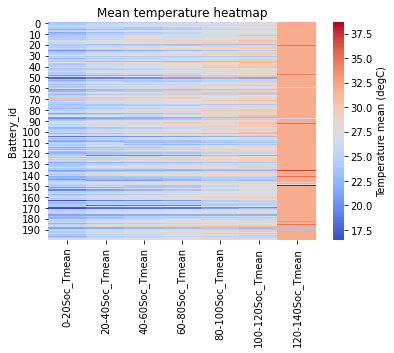

In [9]:
ax = sns.heatmap(df_temp_features.iloc[:,:n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature mean (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Mean temperature heatmap')

Text(0.5, 1.0, 'Max temperature (99th percentile) heatmap')

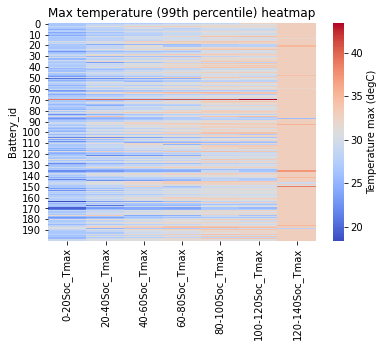

In [10]:
ax = sns.heatmap(df_temp_features.iloc[:,n_bins:2*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature max (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Max temperature (99th percentile) heatmap')

Text(0.5, 1.0, 'Min temperature (1st percentile) heatmap')

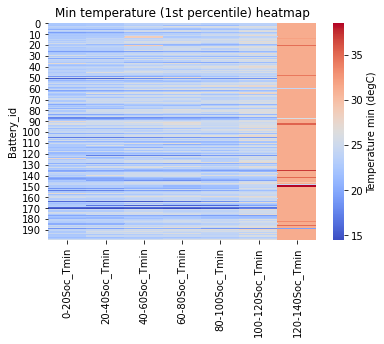

In [11]:
ax = sns.heatmap(df_temp_features.iloc[:,2*n_bins:3*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature min (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Min temperature (1st percentile) heatmap')

Text(0.5, 1.0, 'Temperature Features')

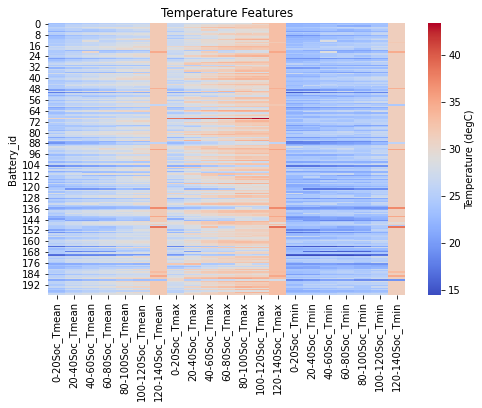

In [12]:
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df_temp_features, annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature (degC)'})
ax.set_ylabel('Battery_id')
plt.title('Temperature Features')

Text(0.5, 1.0, 'Mean absolute power heatmap')

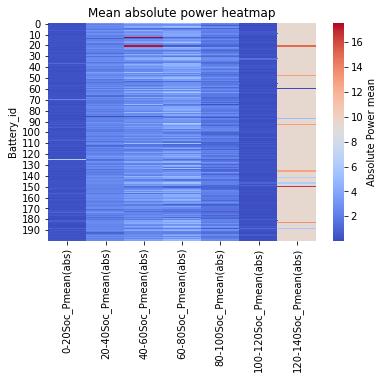

In [13]:
ax = sns.heatmap(df_power_features.iloc[:,:n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Absolute Power mean'})
ax.set_ylabel('Battery_id')
plt.title('Mean absolute power heatmap')

Text(0.5, 1.0, 'Max power (99th percentile) heatmap')

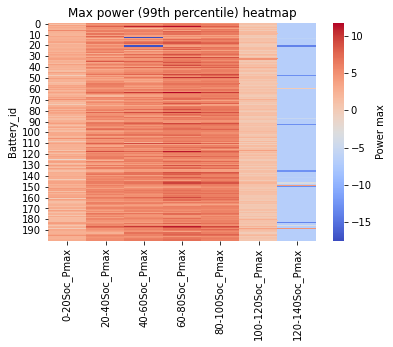

In [14]:
ax = sns.heatmap(df_power_features.iloc[:,n_bins:2*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power max'})
ax.set_ylabel('Battery_id')
plt.title('Max power (99th percentile) heatmap')

Text(0.5, 1.0, 'Min power (1st percentile) heatmap')

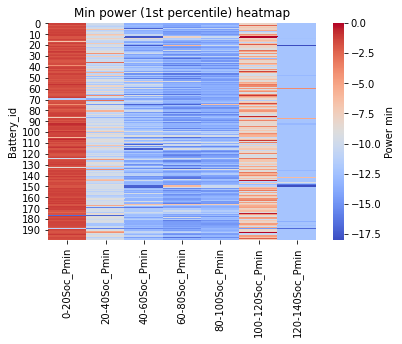

In [15]:
ax = sns.heatmap(df_power_features.iloc[:,2*n_bins:3*n_bins], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power min'})
ax.set_ylabel('Battery_id')
plt.title('Min power (1st percentile) heatmap')

Text(0.5, 1.0, 'Power Features')

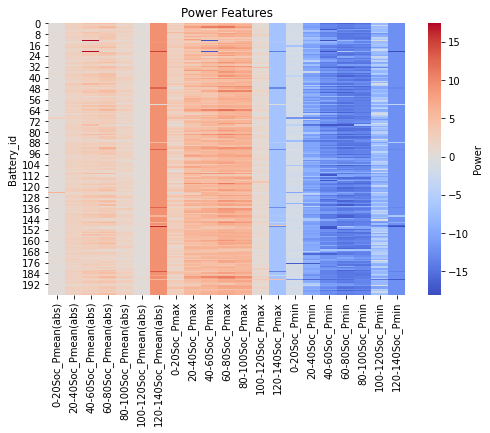

In [16]:
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df_power_features, annot=False, cmap='coolwarm',cbar_kws={'label': 'Power'})
ax.set_ylabel('Battery_id')
plt.title('Power Features')

In [17]:
df_all_features = pd.concat([df_temp_features, df_power_features], axis=1)

In [18]:
df_all_features.head()

,0-20Soc_Tmean,20-40Soc_Tmean,40-60Soc_Tmean,60-80Soc_Tmean,80-100Soc_Tmean,100-120Soc_Tmean,120-140Soc_Tmean,0-20Soc_Tmax,20-40Soc_Tmax,40-60Soc_Tmax,...,80-100Soc_Pmax,100-120Soc_Pmax,120-140Soc_Pmax,0-20Soc_Pmin,20-40Soc_Pmin,40-60Soc_Pmin,60-80Soc_Pmin,80-100Soc_Pmin,100-120Soc_Pmin,120-140Soc_Pmin
0,23.318433,24.193505,24.737020,25.448295,26.018926,26.427842,32.029054,26.863630,27.125315,27.535775,...,4.890137,0.998696,-6.687241,-1.286198,-10.787720,-14.893882,-16.028503,-14.983502,-7.917317,-12.211193
1,24.236325,25.572231,26.325027,26.807814,27.454200,27.677618,32.029054,26.855619,28.748547,29.519341,...,6.369960,0.981605,-6.687241,-1.241038,-9.978214,-13.386000,-13.739121,-13.749699,-7.940887,-12.211193
2,23.983684,25.860432,26.129954,26.279359,26.366716,27.369462,32.029054,26.596292,28.959419,30.015061,...,6.207679,0.078136,-6.687241,-1.935610,-10.426899,-12.783492,-14.113933,-12.871320,-2.410841,-12.211193
3,25.673549,27.107258,28.311296,29.147229,29.205068,29.436506,32.029054,28.736553,30.931289,32.784070,...,8.105012,0.704880,-6.687241,-1.358714,-11.159777,-13.239817,-13.966980,-13.177683,-7.519223,-12.211193
4,25.101141,25.590867,26.575427,27.565157,28.455017,28.604493,32.029054,27.236484,28.449943,29.789425,...,6.169040,1.561378,-6.687241,-1.443623,-10.115800,-13.504141,-14.999376,-14.521324,-6.901981,-12.211193


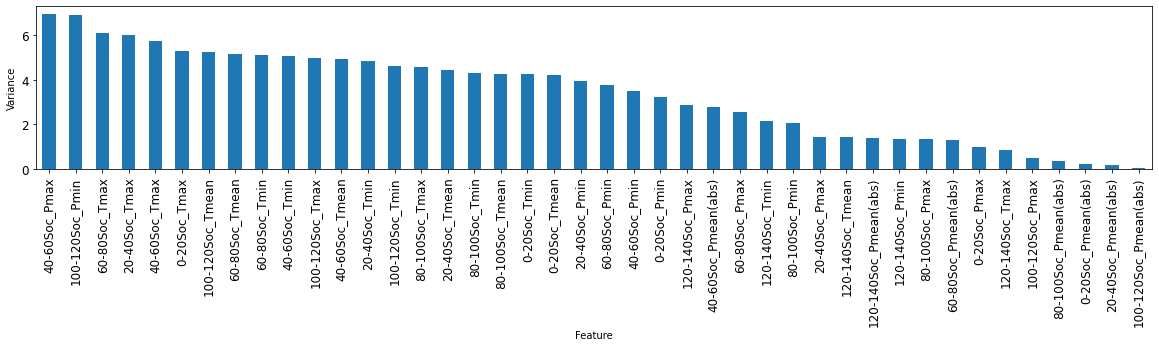

In [19]:
variances = df_all_features.var().sort_values(ascending=False)
f, ax = plt.subplots(figsize=(20,3))
ax = variances.iloc[:60].plot.bar()
ax.set_xlabel('Feature')
ax.set_ylabel('Variance')
ax.tick_params(labelsize=12)

PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#Important to scale the features!
st_temp_features =  StandardScaler().fit_transform(df_temp_features) # Returns ndarray
st_power_features =  StandardScaler().fit_transform(df_power_features) # Returns ndarray
st_all_features =  StandardScaler().fit_transform(df_all_features) # Returns ndarray
pca_temp = PCA(n_components=10).fit(st_temp_features)
pca_power = PCA(n_components=10).fit(st_power_features)
pca_all = PCA(n_components=10).fit(st_all_features)


In [21]:
# component loadings (correlation coefficient between original variables and the PCA component) 
# From sklearn:
# components_ndarray of shape (n_components, n_features)
# Principal axes in feature space, representing the directions of maximum variance in the data.
# The components are sorted by explained_variance_.
pca_temp_loadings = pca_temp.components_
pca_power_loadings = pca_power.components_
pca_all_loadings = pca_all.components_
num_pc_temp = pca_temp.n_features_
num_pc_power = pca_power.n_features_
num_pc_all = pca_all.n_features_

In [22]:
# Re Temperature PCA
pc_temp_list = ["PC"+str(i) for i in list(range(1, num_pc_temp+1))]
df_temp_loadings = pd.DataFrame.from_dict(dict(zip(pc_temp_list, pca_temp_loadings)))
df_temp_loadings['variable'] = df_temp_features.columns.values
df_temp_loadings = df_temp_loadings.set_index('variable')
# Re Power PCA
pc_power_list = ["PC"+str(i) for i in list(range(1, num_pc_power+1))]
df_power_loadings = pd.DataFrame.from_dict(dict(zip(pc_power_list, pca_power_loadings)))
df_power_loadings['variable'] = df_power_features.columns.values
df_power_loadings = df_power_loadings.set_index('variable')
# Re 'All' PCA
pc_all_list = ["PC"+str(i) for i in list(range(1, num_pc_all+1))]
df_all_loadings = pd.DataFrame.from_dict(dict(zip(pc_all_list, pca_all_loadings)))
df_all_loadings['variable'] = df_all_features.columns.values
df_all_loadings = df_all_loadings.set_index('variable')

Text(0, 0.5, 'Proportion of variance (%)')

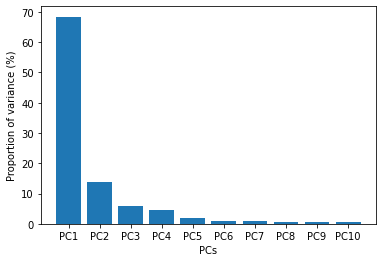

In [26]:
# Re Temperature PCA
num_PCs=10
plt.bar(pc_temp_list[:num_PCs], height = pca_temp.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Proportion of variance (%)')

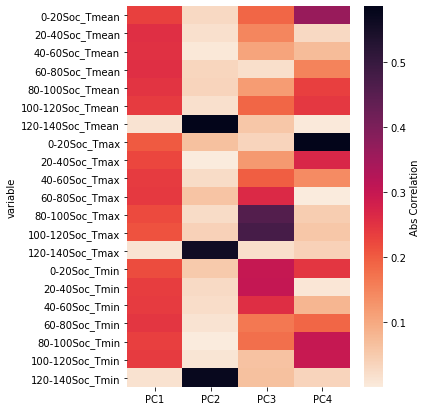

In [27]:
# Re Temperature PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,7))
ax = sns.heatmap(df_temp_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

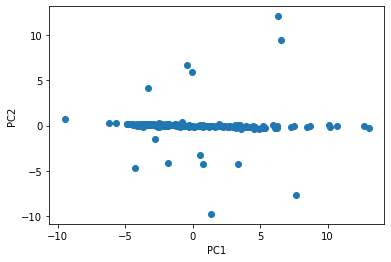

In [28]:
# Re Temperature PCA
pca_temp_scores = PCA().fit_transform(st_temp_features)
pca_temp_scores
#2D plot
PC1 = pca_temp_scores[:,0]
PC2 = pca_temp_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0.5, 0, 'PC3')

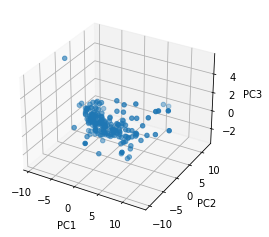

In [29]:
# Re Temperature PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_temp_scores[:,0]
ys = pca_temp_scores[:,1]
zs = pca_temp_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Text(0, 0.5, 'Proportion of variance (%)')

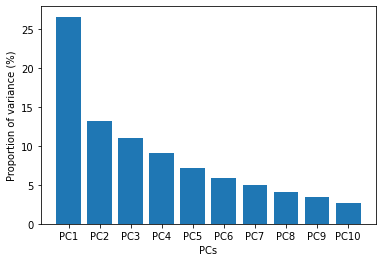

In [30]:
# Re Power PCA
num_PCs=10
plt.bar(pc_power_list[:num_PCs], height = pca_power.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Proportion of variance (%)')

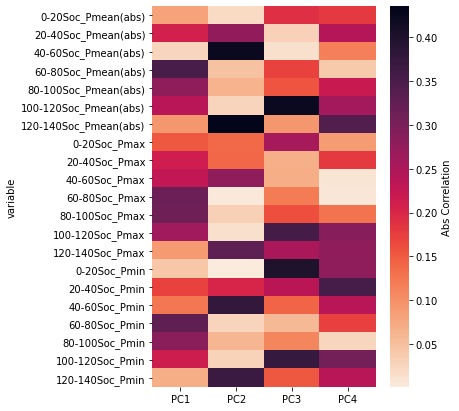

In [31]:
# Re Power PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,7))
ax = sns.heatmap(df_power_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

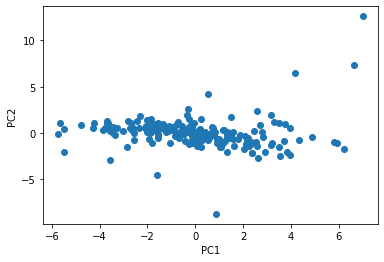

In [32]:
# Re Power PCA
pca_power_scores = PCA().fit_transform(st_power_features)
pca_power_scores
#2D plot
PC1 = pca_power_scores[:,0]
PC2 = pca_power_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0.5, 0, 'PC3')

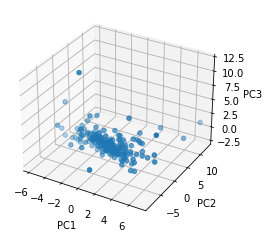

In [33]:
# Re Power PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_power_scores[:,0]
ys = pca_power_scores[:,1]
zs = pca_power_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Text(0, 0.5, 'Explained variance (%)')

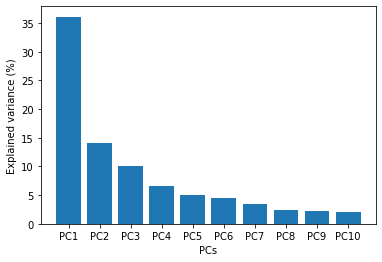

In [34]:
# Re 'All' PCA
num_PCs=10
plt.bar(pc_all_list[:num_PCs], height = pca_all.explained_variance_ratio_[:num_PCs]*100)
plt.xlabel('PCs')
plt.ylabel('Explained variance (%)')

In [35]:
df_all_loadings.shape

(42, 10)

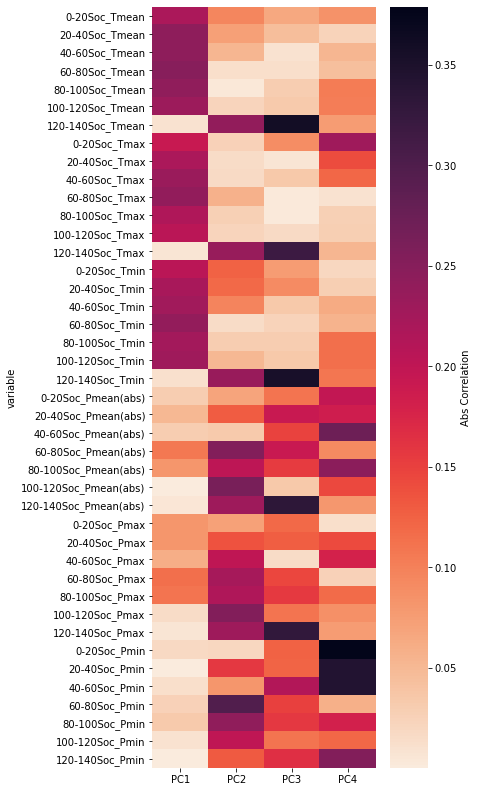

In [36]:
# Re 'All' PCA
num_PCs = 4
f, ax = plt.subplots(figsize=(5,14))
ax = sns.heatmap(df_all_loadings.iloc[:, :num_PCs].abs(), annot=False, cmap='rocket_r', cbar_kws={'label': 'Abs Correlation'})
ax.set_ylabel('variable')
plt.show()

Text(0, 0.5, 'PC2')

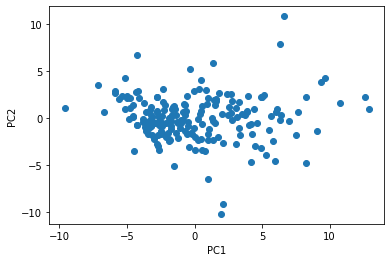

In [37]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,0]
PC2 = pca_all_scores[:,1]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC3')

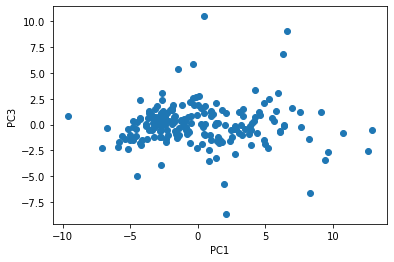

In [38]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,0]
PC2 = pca_all_scores[:,2]
plt.scatter(PC1, PC2)
plt.xlabel("PC1")
plt.ylabel("PC3")

Text(0, 0.5, 'PC3')

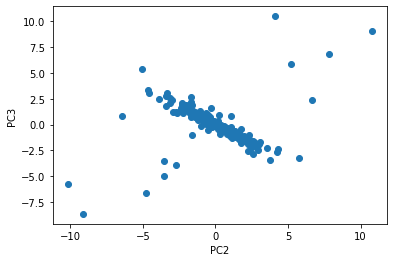

In [39]:
# Re 'All' PCA
pca_all_scores = PCA().fit_transform(st_all_features)
pca_all_scores
#2D plot
PC1 = pca_all_scores[:,1]
PC2 = pca_all_scores[:,2]
plt.scatter(PC1, PC2)
plt.xlabel("PC2")
plt.ylabel("PC3")

Text(0.5, 0, 'PC3')

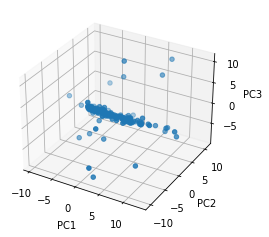

In [40]:
# Re 'All' PCA
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_all_scores[:,0]
ys = pca_all_scores[:,1]
zs = pca_all_scores[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

Clustering using 'All' PCA

In [41]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
estimator = KMeans(n_clusters=4, random_state=0)
estimator.fit(pca_all_scores[:,:2])
labels = estimator.labels_

In [42]:
norm = matplotlib.colors.Normalize(vmin=labels.min(), vmax=labels.max())
cmap = cm.Set2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
c=list(labels.astype(float))
for i, colour in enumerate(c):
    c[i] = cm.Set2(colour) #Using the same in seaborn later
    c[i] = m.to_rgba(colour)

Text(0, 0.5, 'PC2\n(14.0 % of data variance)')

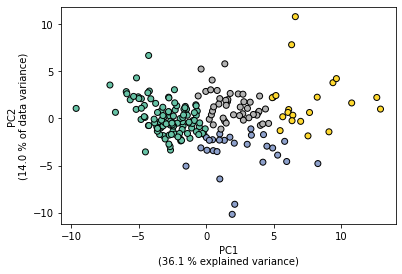

In [43]:
f, ax = plt.subplots()
x = pca_all_scores[:,0]
y = pca_all_scores[:,1]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC1\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC2\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[1]*100))

Text(0, 0.5, 'PC3\n(10.0 % of data variance)')

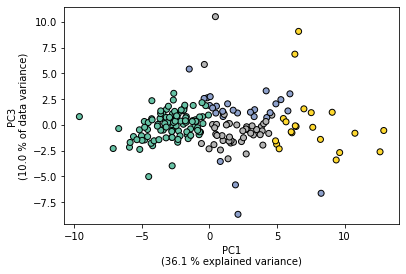

In [44]:
f, ax = plt.subplots()
x = pca_all_scores[:,0]
y = pca_all_scores[:,2]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC1\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC3\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[2]*100))

Text(0, 0.5, 'PC3\n(10.0 % of data variance)')

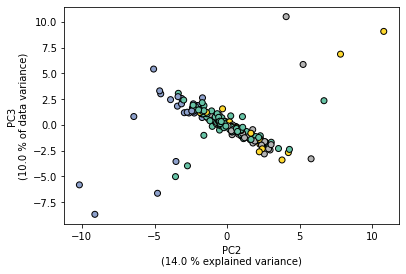

In [45]:
f, ax = plt.subplots()
x = pca_all_scores[:,1]
y = pca_all_scores[:,2]
ax.scatter(x, y, c=c, edgecolor="k")
ax.set_xlabel("PC2\n({:.1f} % explained variance)".format(pca_all.explained_variance_ratio_[1]*100))
ax.set_ylabel("PC3\n({:.1f} % of data variance)".format(pca_all.explained_variance_ratio_[2]*100))

Text(0.5, 0, 'PC3')

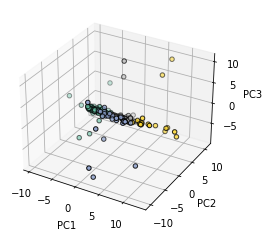

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = pca_all_scores[:,0]
ys = pca_all_scores[:,1]
zs = pca_all_scores[:,2]
ax.scatter(xs, ys, zs, c=c, edgecolor="k")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [47]:
df_temp_features_clustered = pd.DataFrame.copy(df_temp_features)
df_temp_features_clustered["cluster"] = labels
df_power_features_clustered = pd.DataFrame.copy(df_power_features)
df_power_features_clustered["cluster"] = labels
df_all_features_clustered = pd.DataFrame.copy(df_all_features)
df_all_features_clustered["cluster"] = labels

In [48]:
df_temp_features_clustered.to_csv('df_temp_features_clustered.csv', index = False)

In [49]:
df_power_features_clustered.to_csv('df_power_features_clustered.csv', index = False)

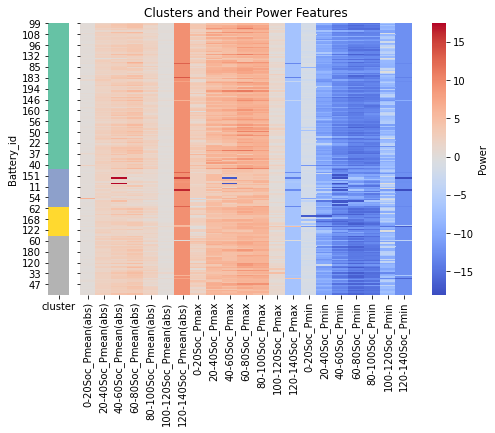

In [50]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5),sharey=True, gridspec_kw={'width_ratios': [1, 20]})
plt.subplots_adjust(wspace=0.05)
g1 = sns.heatmap(df_power_features_clustered.sort_values('cluster').iloc[:,-1:], annot=False, cmap='Set2', ax=ax1, cbar=False)
g2 = sns.heatmap(df_power_features_clustered.sort_values('cluster').iloc[:,:-1], annot=False, cmap='coolwarm',cbar_kws={'label': 'Power'}, ax=ax2)
ax1.set_ylabel('Battery_id')
ax2.set_title('Clusters and their Power Features')
dir = 'c:\\Users\\egaliounas\\OneDrive - University College London\\Extracurricular\\BatteryDev2022BBoxx\\BatteryDevBBoxx\\'
filename = 'pca_all_clusters_and_power_features'
f.savefig(dir+'images\\'+filename, dpi=200)

Text(0.5, 1.0, 'Clusters and their Temperature Features')

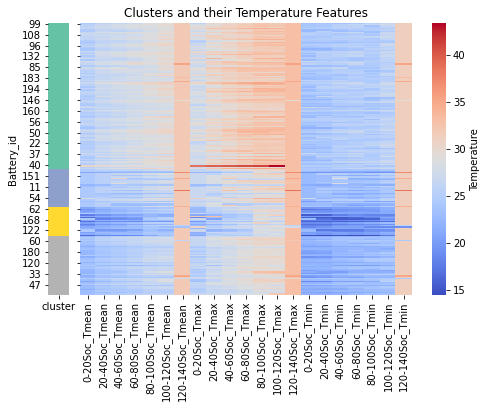

In [51]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5),sharey=True, gridspec_kw={'width_ratios': [1, 20]})
plt.subplots_adjust(wspace=0.05)
g1 = sns.heatmap(df_temp_features_clustered.sort_values('cluster').iloc[:,-1:], annot=False, cmap='Set2', ax=ax1, cbar=False)
g2 = sns.heatmap(df_temp_features_clustered.sort_values('cluster').iloc[:,:-1], annot=False, cmap='coolwarm',cbar_kws={'label': 'Temperature'}, ax=ax2)
ax1.set_ylabel('Battery_id')
ax2.set_title('Clusters and their Temperature Features')